# Interconnect Services

During the process of this entire document, we will analyze the data provided by the company, follow the work plan, and develop a useful solution that meets the required expectations for predicting customer churn.

# Problem Description

The telecom operator Interconnect would like to be able to predict its churn rate. If a customer is found to be planning to leave, he or she will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of its customers' personal data, including information about their plans and contracts.

### Problems Perspective

Interconnect provides primarily two types of services:

1. Landline telephone communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up over a telephone line (DSL, _digital subscriber line_) or over a fiber optic cable.

Some other services offered by the company include:

- Internet security: antivirus software (_DeviceProtection_) and a malicious Web site blocker (_OnlineSecurity_).
- A technical support hotline (_TechnicalSupport_).
- Cloud file storage and data backup (_BackupOnline_).
- TV streaming (_StreamingTV_) and movie directory (_StreamingMovies_).

Customers can choose between a monthly payment or sign a 1 or 2 year contract. You can use several payment methods and receive an electronic invoice after a transaction.

### Data description

The data consists of files obtained from different sources:

- `contract.csv` - contract information;
- `personal.csv` - customer's personal data;
- `internet.csv` - information about Internet services;
- `phone.csv` - information about telephone services.

In each file, the `customerID` column contains a unique code assigned to each customer. The contract information is valid as of February 1, 2020.

## Libraries and Data loading

In [53]:
# Pandas for dataset management
import pandas as pd
# Sklearn for machine learning practice and modeling
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as skmet
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
# Plotly and Seaborn for displaying data in dynamic charts
import seaborn as sns
import matplotlib.pyplot as plt
# Numpy for specific matrix and numerical operations
import numpy as np
# Import the LightGBM model to test different effectiveness
import lightgbm as lgb

In [19]:
# We will reference our csv files to load the data into dataframes
# Contract
df_contract = pd.read_csv('../datasets/contract.csv')
# Personal
df_personal = pd.read_csv('../datasets/personal.csv')
# Internet
df_internet = pd.read_csv('../datasets/internet.csv')
# Phone
df_phone = pd.read_csv('../datasets/phone.csv')

## Merging Dataframes

Reviewing all the dataframes, we can see that each one uses the customer ID as the way to identify records. This can help us create a complete dataframe with all the characteristics of each customer.

In [20]:
# Let's check the dimensions of the dataframes
print(f"Contract:  {df_contract.shape}")
print(f"Personal:  {df_personal.shape}")
print(f"Internet:  {df_internet.shape}")
print(f"Phone:     {df_phone.shape}")

Contract:  (7043, 8)
Personal:  (7043, 5)
Internet:  (5517, 8)
Phone:     (6361, 2)


We can observe that not all dataframes contain all registered customers, since 7043 should be our total number of customers.

We will choose to take all the IDs that appear in all four dataframes together to know how many customers have complete information available.

In [21]:
# Take the ids from each dataframe and keep only those that are not repeated
common_ids = set(df_contract['customerID']) & set(df_personal['customerID']) & set(df_internet['customerID']) & set(df_phone['customerID'])
print(f"We found that {len(common_ids)} customers appear in all 4 tables, so we have all their respective information from each table")

We found that 4835 customers appear in all 4 tables, so we have all their respective information from each table


Now we must merge all the features from the dataframes into a single one so we can work with all the corresponding fields.

In [22]:
# First, we will transform our set list into an array
customerID_list = np.array(list(common_ids))
# Create a dataframe with all the common ids in the 4 dataframes
common_df = pd.DataFrame({'customerID':customerID_list})

In [23]:
# Then we use the dataframe of common ids to merge with each of the dataframes
# and keep only the columns we are interested in
df = df_contract.merge(df_personal, on='customerID', how='inner') \
               .merge(df_internet, on='customerID', how='inner') \
               .merge(df_phone, on='customerID', how='inner')

In [24]:
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


For the remainder of the analysis, we will only use the 4,835 customers identified.

## Data Preprocessing

For data processing, it is necessary to remove outliers, null values, and duplicates, as well as format the data into useful or appropriate data types for each column. These data will be the foundation of our work, so it is essential that they are clean and of high quality in order to work with them effectively.

We obtain a sample of the data and general information about our dataset.

### Dataset Overview

In [25]:
# Display the values of the first 5 customers
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


In [26]:
# General information of the contract.csv dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   gender            4835 non-null   object 
 9   SeniorCitizen     4835 non-null   int64  
 10  Partner           4835 non-null   object 
 11  Dependents        4835 non-null   object 
 12  InternetService   4835 non-null   object 
 13  OnlineSecurity    4835 non-null   object 
 14  OnlineBackup      4835 non-null   object 
 15  DeviceProtection  4835 non-null   object 
 16  TechSupport       4835 non-null   object 


Thanks to the overview provided by the info() method, we can see that there are no null values in the dataframe.

### Formatting and Columns Processing

We can see that we need to format some data types.

* The `BeginDate` column will be transformed to **datetime** type to more easily manipulate date data, and then split into year, month, and day. Meanwhile, the `EndDate` column will be transformed into a binary type to indicate which customers are still active and which have already churned.
* The `Type`, `PaymentMethod`, and `InternetService` columns can be transformed using One Hot Encoding, converting **object** type data to **numeric** type.
* The `TotalCharges` column should also be of **float** type since it expresses the total cost of the service.
* The columns `PaperlessBilling`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, and `MultipleLines` can be converted to binary type since they only contain "Yes" or "No" values.
* The `gender` column can also be transformed into a binary column, with males as 1 and females as 0.demos observar que necesitamos formatear algunos tipos de datos.

#### BeginDate and EndDate

In [27]:
# Check the values contained in the column
df['EndDate'].value_counts()

EndDate
No                     3249
2019-11-01 00:00:00     414
2019-10-01 00:00:00     401
2019-12-01 00:00:00     392
2020-01-01 00:00:00     379
Name: count, dtype: int64

In [28]:
# We will transform the BeginDate column to datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
# Split the BeginDate column into year, month, and day
df['BeginYear'] = df['BeginDate'].dt.year
df['BeginMonth'] = df['BeginDate'].dt.month
df['BeginDay'] = df['BeginDate'].dt.day
# We remove the BeginDate column
df = df.drop(['BeginDate'],axis=1)
# and we will transform the EndDate column to binary
df['EndDate'] = df.apply(lambda row: 0 if row['EndDate'] in 'No' else 1, axis=1)
df['EndDate'] = df['EndDate'].astype('int64')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   EndDate           4835 non-null   int64  
 2   Type              4835 non-null   object 
 3   PaperlessBilling  4835 non-null   object 
 4   PaymentMethod     4835 non-null   object 
 5   MonthlyCharges    4835 non-null   float64
 6   TotalCharges      4835 non-null   object 
 7   gender            4835 non-null   object 
 8   SeniorCitizen     4835 non-null   int64  
 9   Partner           4835 non-null   object 
 10  Dependents        4835 non-null   object 
 11  InternetService   4835 non-null   object 
 12  OnlineSecurity    4835 non-null   object 
 13  OnlineBackup      4835 non-null   object 
 14  DeviceProtection  4835 non-null   object 
 15  TechSupport       4835 non-null   object 
 16  StreamingTV       4835 non-null   object 


#### Type, PaymentMethod, InternetService

In [30]:
# We create the OneHotEncoding columns, where if the value matches the column name, it will be represented as 1, otherwise as 0
one_hot_type = pd.get_dummies(df["Type"], prefix = 'Type')
one_hot_paymentMethod = pd.get_dummies(df["PaymentMethod"], prefix = 'PaymentMethod')
one_hot_internetService = pd.get_dummies(df["InternetService"], prefix = 'InternetService')

In [31]:
# Join the OHE columns to our dataframe
df = pd.concat([df, one_hot_type, one_hot_paymentMethod, one_hot_internetService], axis=1)
df = df.drop('Type', axis=1)
df = df.drop('PaymentMethod', axis=1)
df = df.drop('InternetService', axis=1)
df.columns

Index(['customerID', 'EndDate', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'BeginYear',
       'BeginMonth', 'BeginDay', 'Type_Month-to-month', 'Type_One year',
       'Type_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic'],
      dtype='object')

#### TotalCharges

In [32]:
print(f"Number of customers with empty total charges: {len(df[df['TotalCharges'] == ' '])}")

Number of customers with empty total charges: 3


We found empty total charges. Since only 3 out of our more than 4,385 registered customers have this issue, we will choose to remove these records so they do not interfere with the results or data filtering.

In [33]:
# Remove rows with empty values in the TotalCharges column
df = df[df['TotalCharges'] != ' ']
len(df)

4832

Now we only have 4,832 customers in our dataset

In [34]:
# Check if it is possible to convert the "TotalCharges" column from "object" to "float"
np.array_equal(pd.to_numeric(df['TotalCharges'], errors='coerce'), df['TotalCharges'].astype('float')) # False

True

In [35]:
# Convert the values to float and assign the float type to the column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').astype('float')

#### Columnas Binarias "Yes" y "No"

In [36]:
# Check the existing values in the column
columnsBinary = ["PaperlessBilling",
                 "Partner",
                 "Dependents",
                 "OnlineSecurity",
                 "OnlineBackup",
                 "DeviceProtection",
                 "TechSupport",
                 "StreamingTV",
                 "StreamingMovies",
                 "MultipleLines"]

In [37]:
# Iterate over all columns that have "Yes" and "No" values
for col in columnsBinary:
    print(f"{col}:")
    # Before the change
    print(f"{df[col].value_counts().index.values} {df[col].dtype}")
    # Replace value with True when the word "Yes" is found and False when the word "No" is found
    df[col] = df[col].apply(lambda x: 1 if "Yes" in x else 0)
    # After the change
    print(f"{df[col].value_counts().index.values} {df[col].dtype}")
    print()


PaperlessBilling:
['Yes' 'No'] object
[1 0] int64

Partner:
['No' 'Yes'] object
[0 1] int64

Dependents:
['No' 'Yes'] object
[0 1] int64

OnlineSecurity:
['No' 'Yes'] object
[0 1] int64

OnlineBackup:
['No' 'Yes'] object
[0 1] int64

DeviceProtection:
['No' 'Yes'] object
[0 1] int64

TechSupport:
['No' 'Yes'] object
[0 1] int64

StreamingTV:
['Yes' 'No'] object
[1 0] int64

StreamingMovies:
['Yes' 'No'] object
[1 0] int64

MultipleLines:
['Yes' 'No'] object
[1 0] int64



In [38]:
# Check the data type of the column
df['PaperlessBilling'].dtype

dtype('int64')

#### Gender

In [39]:
# Finally, we convert the gender column to binary to represent males as 1 and females as 0
# This will help with processing when training the model
df['gender'] = df['gender'].apply(lambda g: 0 if 'Female' in g else 1)
# Display the count of each value in the gender column
df['gender'].value_counts()

gender
1    2424
0    2408
Name: count, dtype: int64

In [40]:
# Confirm the type
df['gender'].dtype

dtype('int64')

#### Fin de el Procesamiento de datos

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4832 entries, 0 to 4834
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               4832 non-null   object 
 1   EndDate                                  4832 non-null   int64  
 2   PaperlessBilling                         4832 non-null   int64  
 3   MonthlyCharges                           4832 non-null   float64
 4   TotalCharges                             4832 non-null   float64
 5   gender                                   4832 non-null   int64  
 6   SeniorCitizen                            4832 non-null   int64  
 7   Partner                                  4832 non-null   int64  
 8   Dependents                               4832 non-null   int64  
 9   OnlineSecurity                           4832 non-null   int64  
 10  OnlineBackup                             4832 non-nul

We can observe that all our columns have now been converted to numerical variables, which will help us use them as predictive features in the machine learning model.

In [42]:
# Finally, we display the new data
df.head(5)

,customerID,EndDate,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,...,BeginDay,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic
0,5575-GNVDE,0,0,56.95,1889.50,1,0,0,0,1,...,1,False,True,False,False,False,False,True,True,False
1,3668-QPYBK,1,1,53.85,108.15,1,0,0,0,1,...,1,True,False,False,False,False,False,True,True,False
2,9237-HQITU,1,1,70.70,151.65,0,0,0,0,0,...,1,True,False,False,False,False,True,False,False,True
3,9305-CDSKC,1,1,99.65,820.50,0,0,0,0,0,...,1,True,False,False,False,False,True,False,False,True
4,1452-KIOVK,0,1,89.10,1949.40,1,0,0,1,0,...,1,True,False,False,False,True,False,False,False,True


Finally, we can see that all our columns now have appropriate values and types, making analysis and model training much easier.

## Análisis Exploratorio de Datos (EDA)

After cleaning and transforming our data into useful values for our research and analysis, we will perform a statistical data analysis. In this section, we will examine the relationships between the variables in our dataset and create visualizations to help us better understand the figures associated with each feature.

### Correlation Matrix

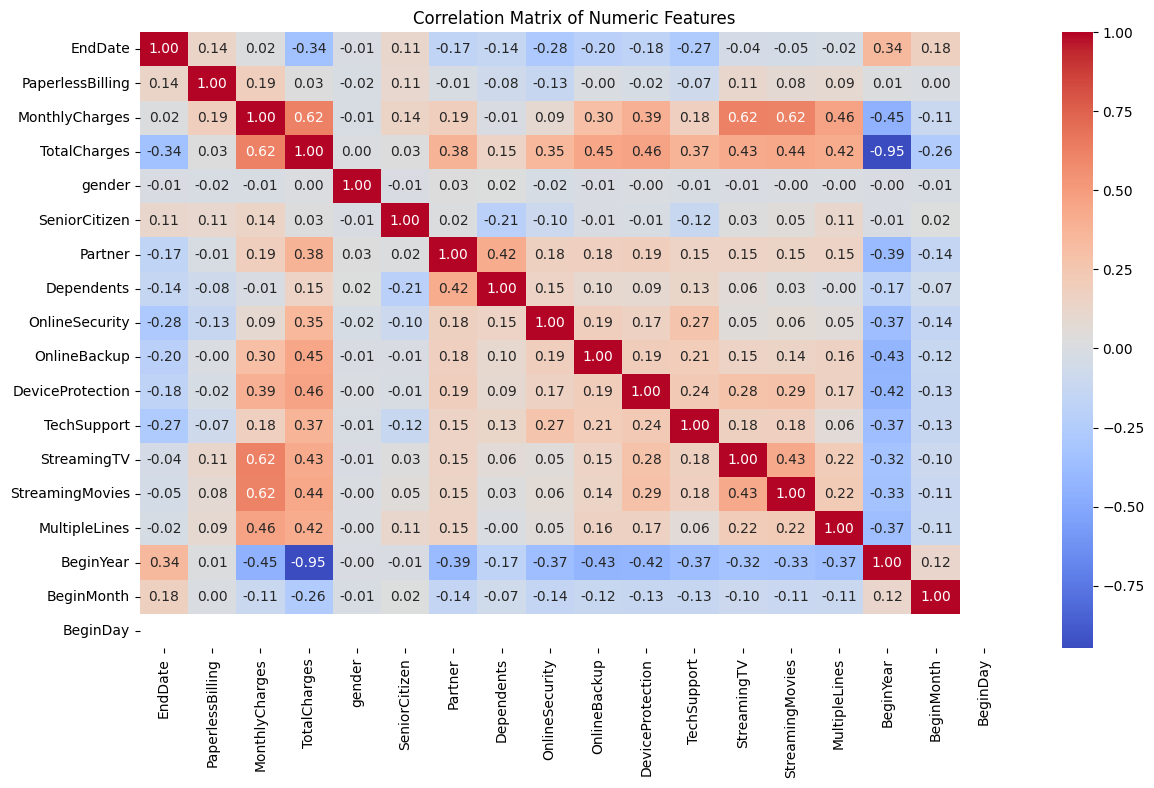

In [43]:
# Get only the numeric columns
df_numeric = df.select_dtypes(include='number')
# We will review the correlation of each column with the others to get a good overview of customer behavior
plt.figure(figsize=(14, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In this extensive chart, we can notice some patterns in the data.
* First, we can see the values that are closer to red tones, which indicate high correlation. For example:
  * `StreamingTV`, `StreamingMovies`, `Multiple Lines`, and `Total Charges` have a strong relationship with the variable `Monthly Charges`.
  * Also, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `Streaming Movies`, `MultipleLines`, and `Type_Two_Year` are highly correlated with the column `Total Charges`. This suggests that all these features impact the total sales price.
* Another pattern we can observe is that the variable `Type_Month_to_Month` seems to have very little correlation with most of the variables in our dataset. This could indicate that it is not a clear indicator of customer behavior.

### Binary Columns

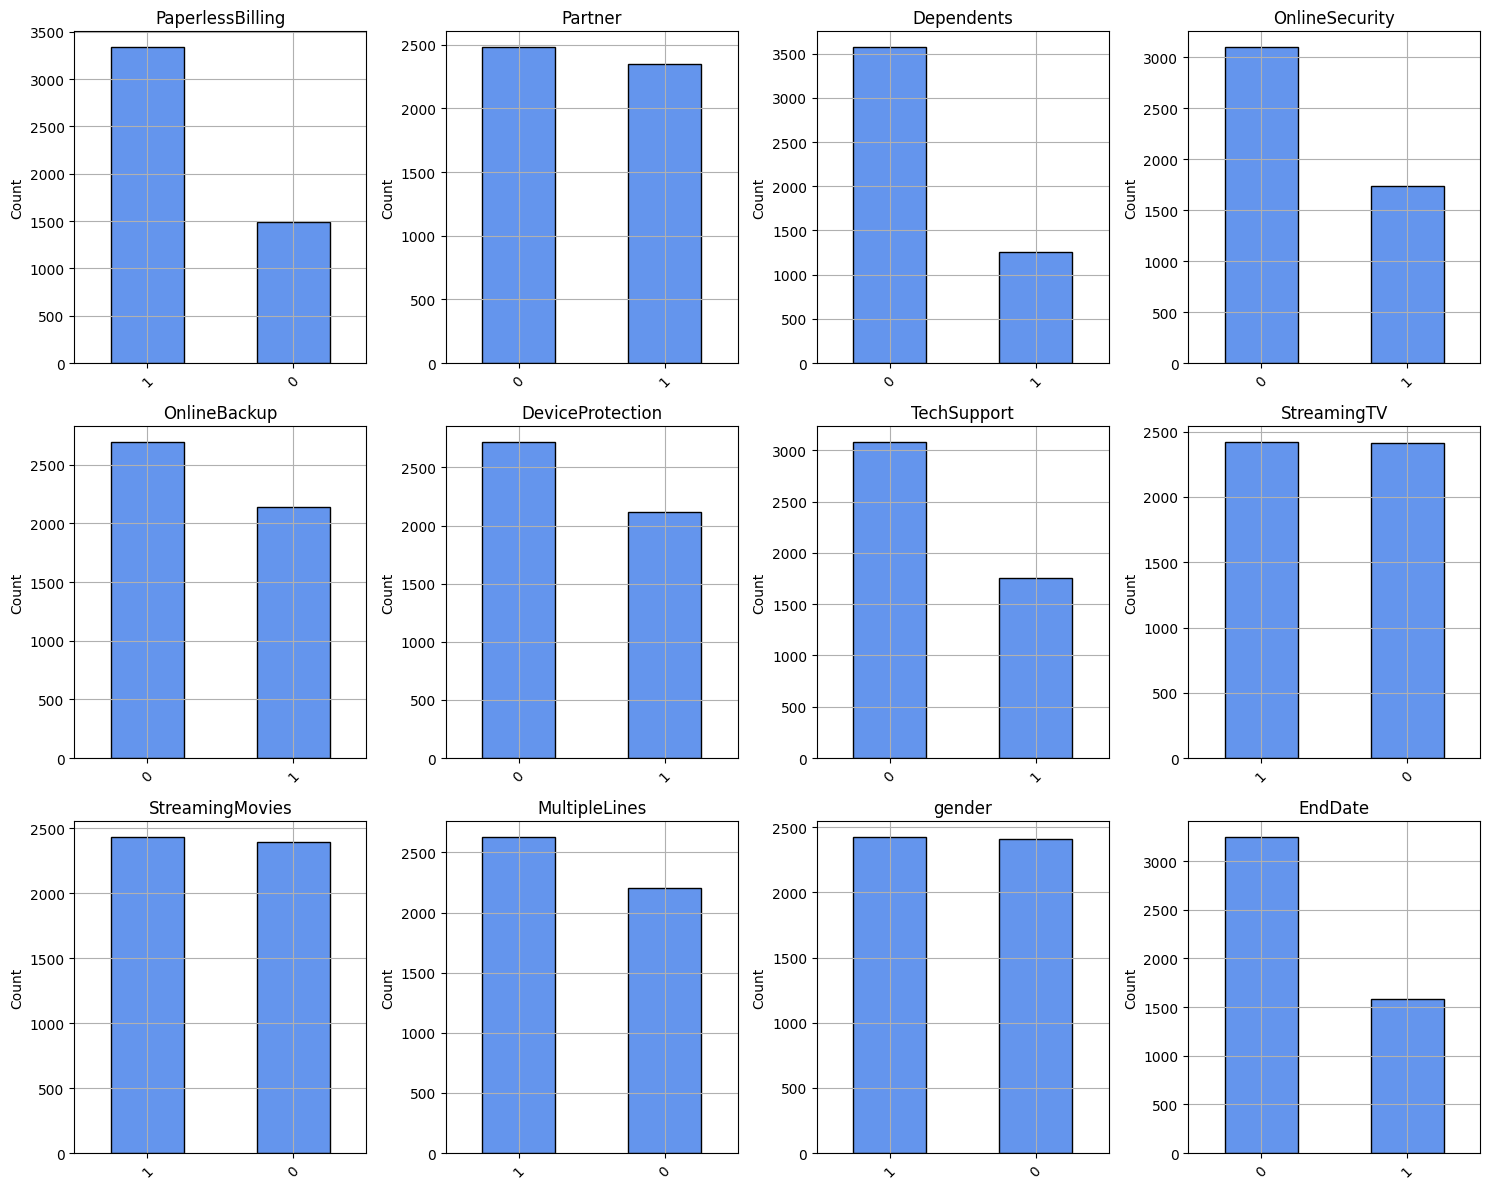

In [44]:
# Use the variable where we stored all the binary column names
# And add the columns 'gender' and 'EndDate'
columnsBinary.extend(['gender','EndDate'])
# Specify a 3x4 grid
n_rows, n_cols = 3, 4
# Create the plot dimensions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()  # to index like a list

# Iterate over each binary column
for i, col in enumerate(columnsBinary):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='cornflowerblue', edgecolor='black')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# Hide unused subplots (if columnsBinary < 12)
for j in range(len(columnsBinary), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

After reviewing the following charts, we can identify the following:

* Some columns have the same or very similar results, such as: `Partner`, `StreamingTV`, `StreamingMovies`, `gender`
  * For the columns Partner and Gender, this is a good sign, as it shows that the data is well distributed among different types of customers.
* Other columns vary a bit, such as `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, and `MultipleLines`.
* Finally, we see larger groups in columns like `PaperlessBilling`, `Dependents`, `TechSupport`, and `EndDate`.
  * From these charts, we can identify that customers prefer online billing.
  * More people have technical support.
  * Slightly less than half of the registered customers have canceled the service.

### Monthly Subscriptions

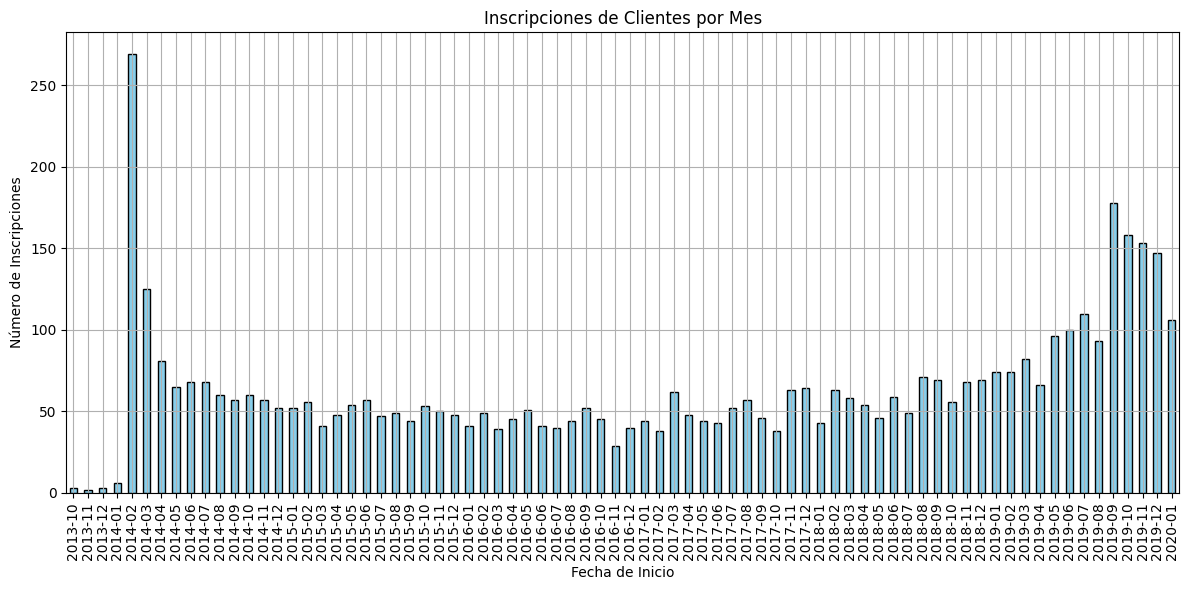

In [45]:
yearMonthInscriptions = pd.to_datetime(df['BeginYear'].astype(str) + '-' + df['BeginMonth'].astype(str))
# Count all customers who signed up in each month
signups_per_month = df.groupby(yearMonthInscriptions.dt.to_period('M')).size()
# Create a chart showing the total number of customers subscribed each month
plt.figure(figsize=(12, 6))
# Create the chart from the dataframe
signups_per_month.plot(kind='bar', color='skyblue', edgecolor='black')
# Set titles and labels
plt.title('Inscripciones de Clientes por Mes')
plt.xlabel('Fecha de Inicio')
plt.ylabel('Número de Inscripciones')
# Rotate the labels to appear vertical
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
# Show the chart
plt.show()

Thanks to this chart, we can see that there was a significant increase in registered customers in February 2014. We can also observe that from then until April 2019, the number of sign-ups remained steady, averaging between 50 and 60 people. Finally, we notice that after all those months, there is a rise in sign-ups starting from September 2019.

## Machine Learning Model Development

We will proceed to train our models using the data obtained from this analysis, in order to make predictions about customer churn from the company's services.

### Creation of Training and Test Features

In [46]:
# First, we will define the variables that will help us determine if a customer will churn
features = df.drop(['EndDate','customerID'], axis = 1)
# And we will get the column with our target, which is the variable we want to predict
target = df['EndDate']

# We will split our data into training and test sets, with the test set being 25% of the available data
features_train, features_valid, target_train, target_valid = train_test_split(
    features,target,test_size=0.25,random_state=12345)

# Scale the price data
scaler = StandardScaler()
features[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(features[['MonthlyCharges', 'TotalCharges']])

In [47]:
# Function to plot AUC-ROC curve with score
def AucRocGraphScore(target_valid, target_proba):
    roc_auc = roc_auc_score(target_valid, target_proba)
    fpr, tpr, _ = roc_curve(target_valid, target_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC Score = {roc_auc:.4f}", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Logistic Regression")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Training the Logistic Regression Model and AUC ROC Curve

In [48]:
# We will use the Logistic Regression model to predict if there is a warning that a customer will churn
model = LogisticRegression(max_iter=1000)
# Model training
model.fit(features_train,target_train)
# Get the predicted probabilities of the model on the validation set
target_proba = model.predict_proba(features_valid)[:, 1]

c:\Users\ISALAS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


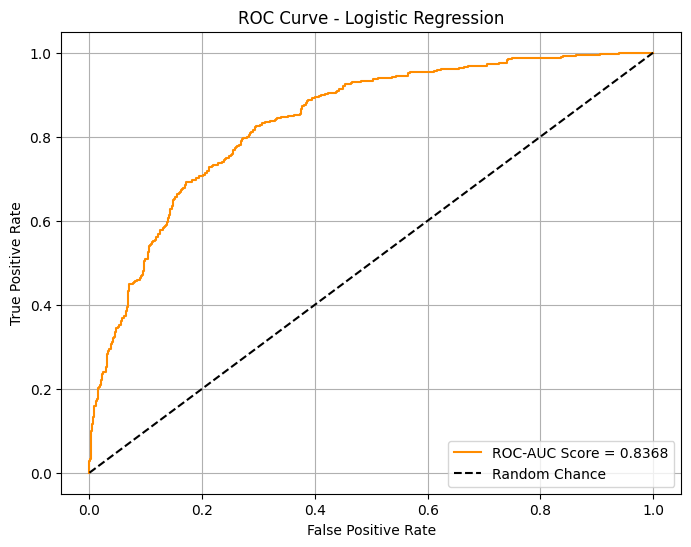

In [49]:
AucRocGraphScore(target_valid, target_proba)

### Training the LightGBM Model and AUC ROC Curve

In [50]:
# Prepare the datasets for our LightGBM model
train_data = lgb.Dataset(features_train, label=target_train)
test_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

In [51]:
# We will use the following parameters for our model
params = {
    # Our objective refers to our target variable, which is binary
    'objective': 'binary',
    # We will use the auc-roc metric
    'metric': 'auc',
    # For the boosting type, we will use gradient boosting descent (gbdt)
    'boosting_type': 'gbdt',
    # With a learning rate of 0.05
    'learning_rate': 0.05,
    # Number of leaves in the model to train
    'num_leaves': 31,
    'verbose': -1,
    # We handle class imbalance by giving more importance to the minority class
    'scale_pos_weight': (target == 0).sum() / (target == 1).sum()  # handle imbalance
}

We can observe that the resulting curve shows a good trend towards accurate predictions, which demonstrates that the model is heading in the right direction.

In [55]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.907516
[200]	valid_0's auc: 0.91878
[300]	valid_0's auc: 0.921977
[400]	valid_0's auc: 0.923682
Early stopping, best iteration is:
[389]	valid_0's auc: 0.923956


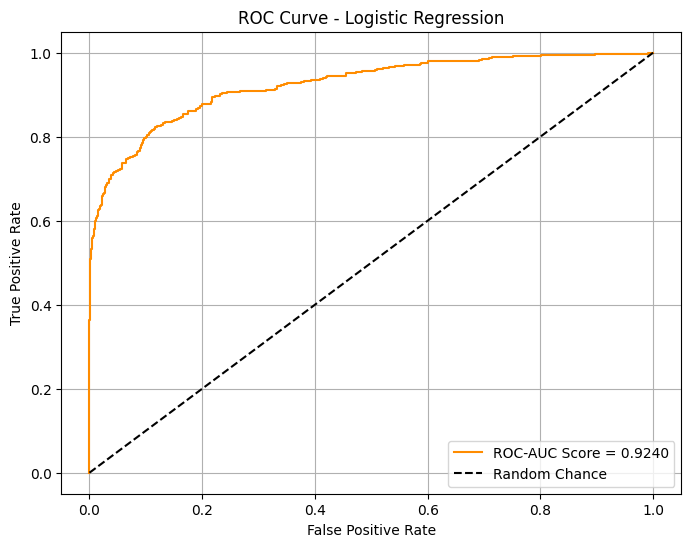

In [56]:
target_proba = model.predict(features_valid, num_iteration=model.best_iteration)
AucRocGraphScore(target_valid, target_proba)

### Results

In [57]:
target_pred = (target_proba >= 0.5).astype(int)
print(classification_report(target_valid, target_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       822
           1       0.78      0.80      0.79       386

    accuracy                           0.87      1208
   macro avg       0.84      0.85      0.85      1208
weighted avg       0.87      0.87      0.87      1208



The classification report shows the performance of the LightGBM model in predicting customer churn. The main metrics are:

- **Precision:** Indicates the proportion of true positives among all positive predictions. A high value means the model makes few false positives.
- **Recall:** Measures the proportion of true positives correctly identified among all actual positive cases. A high value indicates the model detects most actual churns.
- **F1-score:** Is the harmonic mean between precision and recall, providing a balanced view of the model's performance.
- **Support:** Is the number of actual samples of each class in the validation set.

In general, high values for precision, recall, and F1-score for both classes indicate that the model is effective at identifying both customers who will churn and those who will stay. This supports the usefulness of the model for making business decisions aimed at customer retention.

## Conclusion

Thanks to our analysis, we now have a much broader view of user behavior, such as:
* Which dates had the highest user sign-ups
* When sales stabilized
* And the current situation of the company, which has been increasing sales over the last 8 months

The analysis also allowed us to observe the preferences of most customers when using the service, such as:
* Most prefer online billing
* A large portion of customers prefer to have technical support and security
* We also observed that half of those who joined the service ended up leaving, highlighting the importance and urgency of this analysis for the company

Finally, we were able to create two types of models that yielded the following results:
* **Logistic Regression Model**
    * Our logistic regression model achieved an AUC-ROC score of **83.44%**, which means the model performed quite well, correctly predicting customer churn about 83 percent of the time.
* **LightGBM Model**
    * On the other hand, we observed an even better performance with the Gradient Boosting model. Trained on the same data, its performance far surpassed our first model, achieving an **AUC-ROC score of 92.40%**. This indicates it is a highly capable model for making accurate predictions.

After reviewing these results, we can conclude that the initial goal of analyzing and predicting customer churn for the company has been achieved, enabling data-driven decision-making based on the results obtained.

In summary, this analysis has allowed us to deeply understand the behavior and trends of Interconnect's customers. We identified key sign-up periods, the factors influencing user retention or churn, and the predominant preferences regarding services and billing methods. Additionally, the application of robust machine learning models has proven to be a valuable tool for anticipating customer cancellations, allowing the company to design proactive retention strategies. These findings not only strengthen data-driven decision-making but also open the door to future optimizations in service management and personalization, consolidating the company's competitiveness in the market.